<a href="https://colab.research.google.com/github/Tensor-Reloaded/PMP-2025/blob/main/Lab01/Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estimarea Înălțimii Medii a Studenților
Să presupunem că suntem interesați să estimăm înălțimea medie a studenților dintr-o universitate. Nu avem acces la datele întregii populații, dar putem măsura înălțimea unui eșantion aleatoriu de studenți. De asemenea, știm că înălțimile umane urmează aproximativ o distribuție normală.

Obiectivul nostru: Să estimăm înălțimea medie (mu) și variația în înălțimi (deviația standard sigma) a tuturor studenților, pe baza unui eșantion.

## Pasul 1: Simularea Datelor Observate
Pentru a simplifica, vom simula datele noastre observate. Să presupunem că:
- Înălțimea medie reală (true_mu): 170 cm
- Deviația standard reală (true_sigma): 10 cm

Vom genera un eșantion de 100 de studenți ale căror înălțimi le vom utiliza în model.

In [19]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

# Seed pentru reproducibilitate
np.random.seed(12)

# Parametrii reali
true_mu = 170       # Înălțimea medie reală în cm
true_sigma = 10     # Deviația standard reală în cm

# Generăm datele observate (înălțimile studenților)
observed_heights = np.random.normal(true_mu, true_sigma, size=100)

In [20]:
# Configuration pentru PyTensor (necesară pentru Windows)
import os
os.environ['PYTENSOR_FLAGS'] = 'cxx='

# Alternative: configurare directă
try:
    import pytensor
    pytensor.config.cxx = ''
    pytensor.config.mode = 'FAST_RUN'
    pytensor.config.device = 'cpu'
    print("PyTensor configurat pentru modul Python (fără compilare C++)")
except:
    print("PyTensor va fi configurat automat")

PyTensor va fi configurat automat


## Pasul 2: Vizualizarea Datelor
Înainte de a construi modelul, este util să vizualizăm datele.

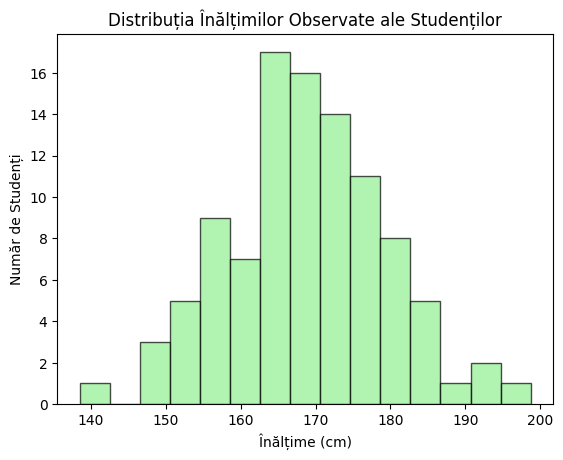

In [21]:
# Afișăm un histogram al înălțimilor observate
plt.hist(observed_heights, bins=15, alpha=0.7, color='lightgreen', edgecolor='black')
plt.title('Distribuția Înălțimilor Observate ale Studenților')
plt.xlabel('Înălțime (cm)')
plt.ylabel('Număr de Studenți')
plt.show()

## Pasul 3: Definirea Modelului Probabilistic
Utilizăm PyMC pentru a defini un model probabilistic care să ne permită să estimăm mu și sigma pe baza datelor observate.

In [22]:
# Definim modelul probabilistic
with pm.Model() as model:
    # Prior pentru înălțimea medie (mu)
    mu = pm.Normal('mu', mu=160, sigma=15)  # Presupunem inițial că media ar putea fi în jur de 160 cm

    # Prior pentru deviația standard (sigma)
    sigma = pm.HalfNormal('sigma', sigma=10)  # Deviația standard trebuie să fie pozitivă

    # Verosimilitatea datelor observate
    heights = pm.Normal('heights', mu=mu, sigma=sigma, observed=observed_heights)

    # Efectuăm eșantionarea MCMC
    print("Începem eșantionarea MCMC...")
    trace = pm.sample(1000, tune=1000, return_inferencedata=True)
    print("Eșantionarea MCMC s-a încheiat.")


Initializing NUTS using jitter+adapt_diag...


Începem eșantionarea MCMC...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]
NUTS: [mu, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.


Eșantionarea MCMC s-a încheiat.


### Explicații:
Am creat un model pe baza urmatoarelor presupuneri:
- Prior pentru mu: Presupunem inițial că înălțimea medie este în jur de 160 cm, cu o incertitudine de 15 cm.
- Prior pentru sigma: Folosim o distribuție HalfNormal deoarece deviația standard nu poate fi negativă.
- Verosimilitatea: Modelăm înălțimile observate ca provenind dintr-o distribuție normală cu parametrii necunoscuți mu și sigma.

## Pasul 4: Analiza Rezultatelor
Rezumatul Posterior

In [23]:
# Rezumatul parametrilor posteriori
print("\nRezumatul estimărilor:")
summary = az.summary(trace, var_names=['mu', 'sigma'])
print(summary)


Rezumatul estimărilor:
          mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu     168.505  1.067  166.610  170.600      0.016    0.017    4305.0   
sigma   10.575  0.757    9.198   12.054      0.012    0.012    4177.0   

       ess_tail  r_hat  
mu       2816.0    1.0  
sigma    2867.0    1.0  


### Interpretare:

- mu: Valoarea estimată pentru înălțimea medie a studenților.
- sigma: Estimarea variației în înălțimi.


## Distribuțiile Posterioare


Plotăm distribuțiile posterioare pentru 'mu' și 'sigma'...


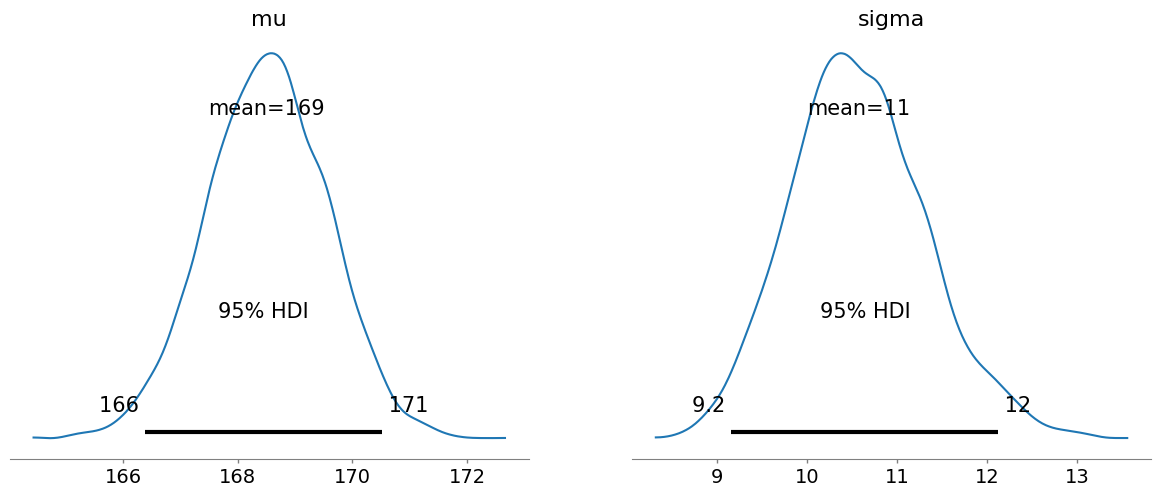

In [24]:
# Afișăm distribuțiile posterioare
print("\nPlotăm distribuțiile posterioare pentru 'mu' și 'sigma'...")
az.plot_posterior(trace, var_names=['mu', 'sigma'], hdi_prob=0.95)
plt.show()

### Interpretare:
Graficul arată distribuțiile probabilistice actualizate ale parametrilor după ce am luat în considerare datele observate.
- Pentru mu: Vedem unde este cel mai probabil să se afle înălțimea medie și cât de siguri suntem de această estimare.
- Pentru sigma: Similar, vedem estimarea pentru deviația standard.

## Traseele MCMC

Plotăm traseele MCMC pentru 'mu' și 'sigma'...


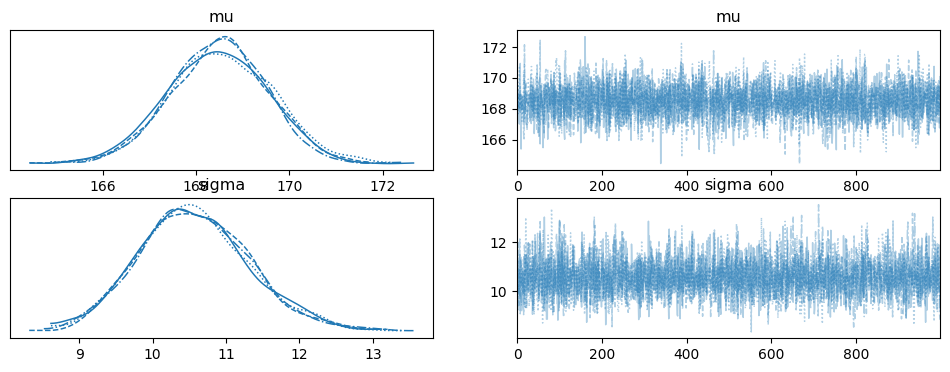

In [25]:
# Plotăm traseele MCMC
print("Plotăm traseele MCMC pentru 'mu' și 'sigma'...")
az.plot_trace(trace, var_names=['mu', 'sigma'])
plt.show()

### Interpretare:

Traseele arată cum valorile estimate pentru mu și sigma au evoluat pe parcursul eșantionării.
Un traseu stabil și bine amestecat indică o eșantionare eficientă și convergența către distribuția posterioară corectă.

## Compararea Valorilor Estimate cu Cele Reale

In [26]:
# Comparam valorile estimate cu valorile reale
estimated_mu = summary.loc['mu', 'mean']
estimated_sigma = summary.loc['sigma', 'mean']
print(f"\nValoarea reală a 'mu' (înălțimea medie reală): {true_mu} cm")
print(f"Valoarea estimată a 'mu': {estimated_mu:.2f} cm")
print(f"Valoarea reală a 'sigma' (deviația standard reală): {true_sigma} cm")
print(f"Valoarea estimată a 'sigma': {estimated_sigma:.2f} cm")


Valoarea reală a 'mu' (înălțimea medie reală): 170 cm
Valoarea estimată a 'mu': 168.50 cm
Valoarea reală a 'sigma' (deviația standard reală): 10 cm
Valoarea estimată a 'sigma': 10.57 cm


### Interpretare:

Observăm cât de aproape sunt estimările noastre de valorile reale folosite pentru a genera datele.
Diferențe mici indică faptul că modelul nostru a funcționat bine.